In [1]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.generative_model_metrics import rmse_over_time_xr,rmse_over_time, vector_correlation_over_time_xr, vector_correlation_over_time, plot_correlation_grid
from ocean_navigation_simulator.generative_error_model.GAN.data_postprocessing import ConvertToError, get_sparse_from_nc

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import ensverif as e


# Create Data from Raw GAN Output

In [5]:
# define paths
# predictions_dir = "../../../data/drifter_data/GAN_samples/2022-12-10_13:04:33"  # contrained
# predictions_dir  = "../../../data/drifter_data/GAN_samples/2022-12-11_10:26:04"  # unconstrained
# predictions_dir = "../../../data/drifter_data/GAN_samples/2022-12-15_19:01:37"
# ground_truth_dir = "../../../data/drifter_data/buoy_preprocessed_test/area1"
predictions_dir = "../../../data/drifter_data/Gen_samples/2022-12-19_10:27:31"
ground_truth_dir = "../../../data/drifter_data/buoy_preprocessed_val/area1"

# define output paths
dir_extension = ""
error_root = f"../../../data/drifter_data/GAN_nc/errors{dir_extension}"
forecast_root = "../../../data/drifter_data/GAN_nc/forecasts"
current_root = "../../../data/drifter_data/GAN_nc/currents"
variogram_data_path = f"../../../data/drifter_data/GAN_nc/sample_volume{dir_extension}.nc"

# remove error files
error_files = os.listdir(error_root)
for error_file in error_files:
    os.remove(os.path.join(error_root, error_file))

# remove current files
current_files = os.listdir(current_root)
for current_file in current_files:
    os.remove(os.path.join(current_root, current_file))

# remove forecast files
fc_files = os.listdir(forecast_root)
for fc_file in fc_files:
    os.remove(os.path.join(forecast_root, fc_file))

recomp_data = True

if recomp_data:
    # init postprocessing class
    eval = ConvertToError(predictions_dir, ground_truth_dir)
    # compute errors
    eval.get_individual_as_nc(error_root, type="error")
    # compute forecasts
    eval.get_individual_as_nc(forecast_root, type="forecast")
    # compute currents
    eval.get_individual_as_nc(current_root, type="current")
    # compute consecutive volume for Variogram Analysis
    ds = eval.get_max_volume_as_nc()
    ds.to_netcdf(variogram_data_path)

# Compute RMSE

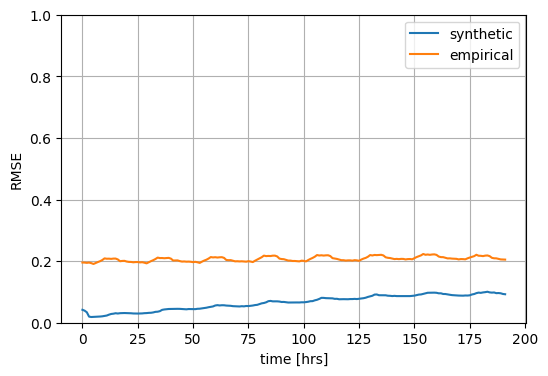

In [6]:
# load synthetic error nc files
files = os.listdir(error_root)
rmse = []
for file in files:
    data = xr.open_dataset(os.path.join(error_root, file), engine="netcdf4")
    rmse.append(rmse_over_time_xr(data, variables=("water_u", "water_v")))
rmse = np.array(rmse).mean(axis=0)

# empirical
error_data_root = "../../../data/drifter_data/dataset_forecast_error/area1_edited"
files = sorted(os.listdir(error_data_root))
rmse_data = []
for file in files[:50]:
    data = pd.read_csv(os.path.join(error_data_root, file))
    rmse_data.append(rmse_over_time(data, variables=("u_error", "v_error"))["rmse"][:192])
# take average for each hour
rmse_data = np.array(rmse_data).mean(axis=0)

fig = plt.figure(figsize=(6,4))
plt.plot(range(len(rmse)), rmse, label="synthetic")
plt.plot(range(len(rmse_data)), rmse_data, label="empirical")
plt.ylim([0, 1.0])
plt.ylabel("RMSE")
plt.xlabel("time [hrs]")
plt.grid()
plt.legend()

# Compute Vector Correlation

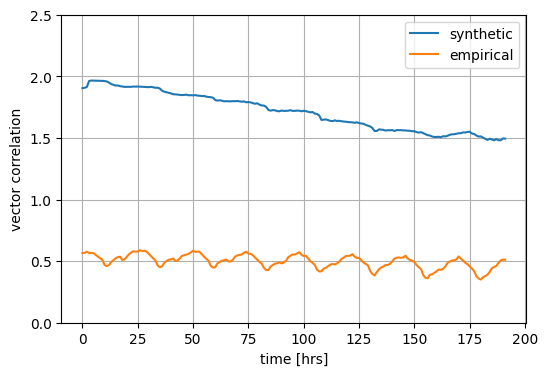

In [7]:
# predicted currents vs forecast

# load forecast nc files and synthetic error nc files
forecast_files = sorted(os.listdir(forecast_root))
error_files = sorted(os.listdir(error_root))

vec_corr = []
for error_file, forecast_file in zip(error_files, forecast_files):
    error_data = xr.open_dataset(os.path.join(error_root, error_file))
    forecast_data = xr.open_dataset(os.path.join(forecast_root, forecast_file))
    temp_vec_corr = vector_correlation_over_time_xr(error_data, forecast_data)
    vec_corr.append(temp_vec_corr)
vec_corr = np.array(vec_corr).mean(axis=0)

# empirical
# use forecast error + forecast or alternatively buoy data directly
# use forecast+error vs forecast
forecast_error_root = "../../../data/drifter_data/dataset_forecast_error/area1_edited"
error_files = sorted(os.listdir(forecast_error_root))[:50]
# print(pd.read_csv(os.path.join(forecast_error_root, error_files[0])).describe())
vec_corr_emp = []
for file in error_files:
    data = pd.read_csv(os.path.join(forecast_error_root, file))
    vec_corr_emp.append(vector_correlation_over_time(data))
vec_corr_emp = np.array(vec_corr_emp).mean(axis=0)[:192]

fig = plt.figure(figsize=(6,4))
plt.plot(range(len(vec_corr)), vec_corr, label="synthetic")
plt.plot(range(len(vec_corr_emp)), vec_corr_emp, label="empirical")
plt.ylim([0, 2.5])
plt.xlabel("time [hrs]")
plt.ylabel("vector correlation")
plt.grid()
plt.legend()

# Plot error distributions

In [ ]:
# plot histogram of buoy data
from scipy.stats import norm

mean_u, std_u = norm.fit(df["u"])
mean_v, std_v = norm.fit(df["v"])

fig, axs = plt.subplots(1,2, figsize=(20, 5))
axs[0].hist(df["u"], bins=30, density=True)
axs[1].hist(df["v"], bins=60, density=True)

# plot pdf
xmin_u, xmax_u = axs[0].get_xlim()
xmin_v, xmax_v = axs[1].get_xlim()
x_u = np.linspace(xmin_u, xmax_u, 100)
x_v = np.linspace(xmin_v, xmax_v, 100)
pdf_u = norm.pdf(x_u, mean_u, std_u)
pdf_v = norm.pdf(x_v, mean_v, std_v)
axs[0].plot(x_u, pdf_u, 'k', linewidth=2)
axs[1].plot(x_v, pdf_v, "k", linewidth=2)
axs[0].set_xlim([-1, 1])
axs[1].set_xlim([-1, 1])

plt.show()

# Compute Variogram

Number of models: 4
Type of model: gaussian_2d
[[2.11485852e-01 1.84531759e+02 2.32639714e+02]
 [2.07652204e-01 2.33082361e+02 2.08976540e+01]
 [2.40108844e-01 1.00897654e+02 1.20290657e+02]
 [3.40753101e-01 2.31790590e+02 1.00897654e+02]]
../../../data/drifter_data/GAN_nc/sample_volume.nc


array([<AxesSubplot:xlabel='space_lag [km]', ylabel='Semivariance'>,
       <AxesSubplot:xlabel='t_lag [hrs]', ylabel='Semivariance'>],
      dtype=object)

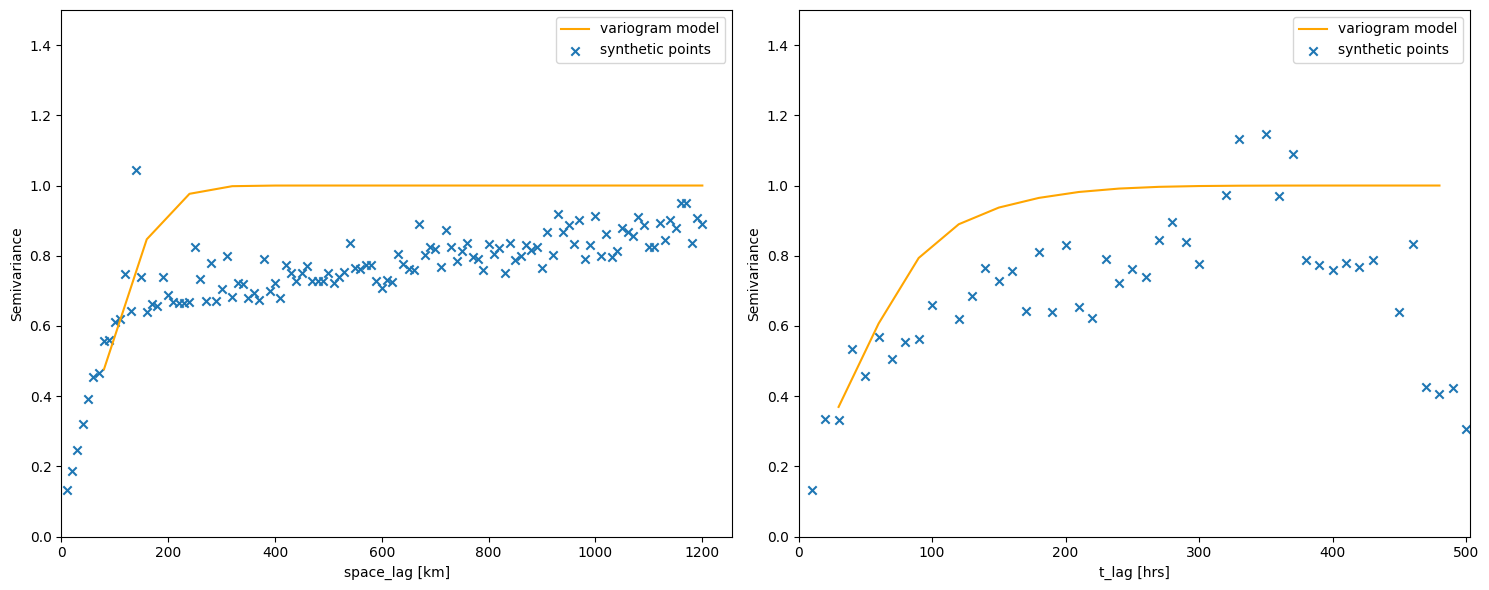

In [8]:
from ocean_navigation_simulator.generative_error_model.variogram.VariogramFitting import VariogramFitting
from ocean_navigation_simulator.generative_error_model.GAN.data_postprocessing import get_sparse_from_nc
from ocean_navigation_simulator.generative_error_model.variogram.Variogram import Variogram
from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram

import os
import pandas as pd

save_dir = "/home/remote_jonas/OceanPlatformControl/data/drifter_data/variogram_tuned"
file_name = "tuned_2d_forecast_variogram_area1_edited2.npy"
file_path = os.path.join(save_dir, file_name)
data = pd.read_csv(file_path)

fitted_v = VariogramFitting(data, ("space_lag", "t_lag"), error_var="u_semivariance")
fitted_v.load_params("/home/remote_jonas/OceanPlatformControl/data/drifter_data/variogram_params/tuned_2d_forecast_variogram_area1_edited2.npy")
_, axs = fitted_v.plot_all_dims(plot_empirical=False)
print(fitted_v.popt)

print(variogram_data_path)
synthetic_data = get_sparse_from_nc(variogram_data_path)

# calculate variogram
v = Variogram(synthetic_data)
v.detrend()
bins, bins_count = v.build_variogram((5, 1), num_workers=2, chunk_size=int(1e6), cross_buoy_pairs_only=False, is_3d=False)

# plot variogram on shared axes
vvis = VisualizeVariogram(variogram=v)
vvis.decrease_variogram_res((10, 10))
view_range = [1200, 500]
vvis.plot_variograms(error_variable="u", label="synthetic points", view_range=view_range, axs_external=axs)

Number of models: 4
Type of model: gaussian_2d
[[2.01706547e-01 2.00897654e+02 2.04855062e+02]
 [2.30915429e-01 2.64812857e+02 4.08076230e+01]
 [2.33040209e-01 1.50897654e+02 1.85936370e+02]
 [3.34337816e-01 6.81139663e+01 3.08976540e+01]]


array([<AxesSubplot:xlabel='space_lag [km]', ylabel='Semivariance'>,
       <AxesSubplot:xlabel='t_lag [hrs]', ylabel='Semivariance'>],
      dtype=object)

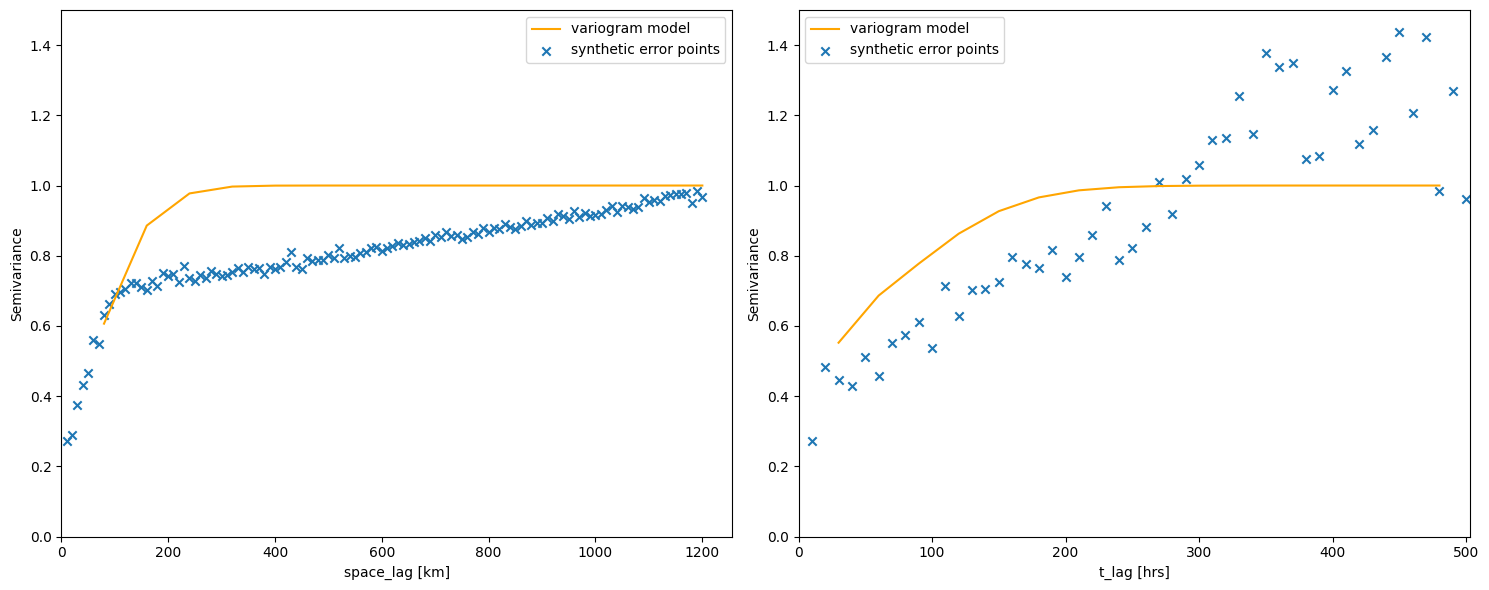

In [33]:
fitted_v = VariogramFitting(data, ("space_lag", "t_lag"), error_var="v_semivariance")
fitted_v.load_params("/home/remote_jonas/OceanPlatformControl/data/drifter_data/variogram_params/tuned_2d_forecast_variogram_area1_edited2.npy")
_, axs = fitted_v.plot_all_dims(plot_empirical=False)
print(fitted_v.popt)

# plot variogram on shared axes
vvis = VisualizeVariogram(variogram=v)
vvis.decrease_variogram_res((10, 10))
view_range = [1200, 500]
vvis.plot_variograms(error_variable="v", label="synthetic error points", view_range=view_range, axs_external=axs)

# Compute Rank Histogram

In [22]:
import ensverif as e

# convert repeated GAN predictions to nc
# predictions_dir = "../../../data/drifter_data/GAN_samples_repeated/2022-12-10_12:16:36"  # constrained
# predictions_dir = "../../../data/drifter_data/GAN_samples_repeated/2022-12-11_10:29:27"  # unconstrained
# predictions_dir = "../../../data/drifter_data/GAN_samples_repeated/2022-12-15_19:01:37"
# ground_truth_dir = "../../../data/drifter_data/GAN_repeated_test/buoy/area1"
predictions_dir = "../../../data/drifter_data/Gen_samples_repeated/2022-12-19_10:27:31"
ground_truth_dir = "../../../data/drifter_data/Gen_repeated_test/buoy/area1"
eval = ConvertToError(predictions_dir, ground_truth_dir)
error_root = "../../../data/drifter_data/Gen_samples_repeated/errors"

# # remove previous files
# error_files = os.listdir(error_root)
# for error_file in error_files:
#     os.remove(os.path.join(error_root, error_file))

# write new errors
eval.get_individual_as_nc(error_root, type="error", duplicate=True)

0


[]


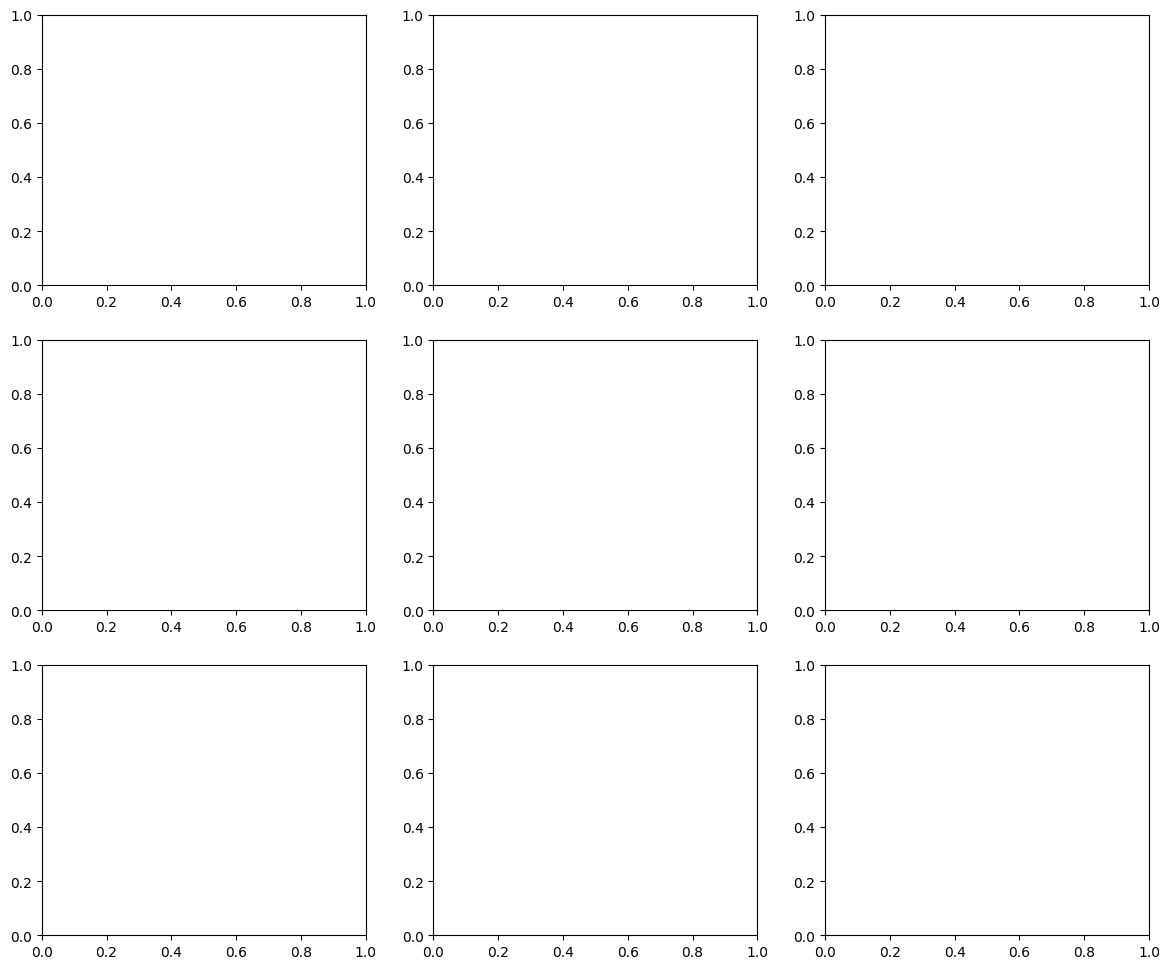

In [14]:
# load GAN predictions
files = os.listdir(error_root)
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for idx, file in enumerate(files[:9]):
    axis = axs[idx%3, idx//3]
    data = xr.open_dataset(os.path.join(error_root, file), engine="netcdf4")
    frame = axis.imshow(np.sqrt(data["water_u"].values[0]**2 + data["water_v"].values[0]**2), origin="lower")
    plt.colorbar(frame, ax=axis, fraction=0.046, pad=0.04)
    axis.set_yticklabels([])
    axis.set_xticklabels([])
    axis.set_xticks([])
    axis.set_yticks([])
plt.tight_layout(pad=1.8)
plt.show()

In [13]:
# load GAN ground truth -> produced using data_preprocessing and func 'save_sparse_as_npy' with type='error'
gt_root = "../../../data/drifter_data/GAN_samples_repeated/gt_errors"
gt_file = sorted(os.listdir(gt_root))[0]
gt = np.load(os.path.join(gt_root, gt_file), allow_pickle=True)[:192]
print(gt.shape, gt_file)

(192, 2, 256, 256) copernicus_forecast_error_lon_[-14625, -125]_lat_[15, 3625]_time_2022-09-21T12:30:00Z__2022-09-30T23:30:00Z.npy


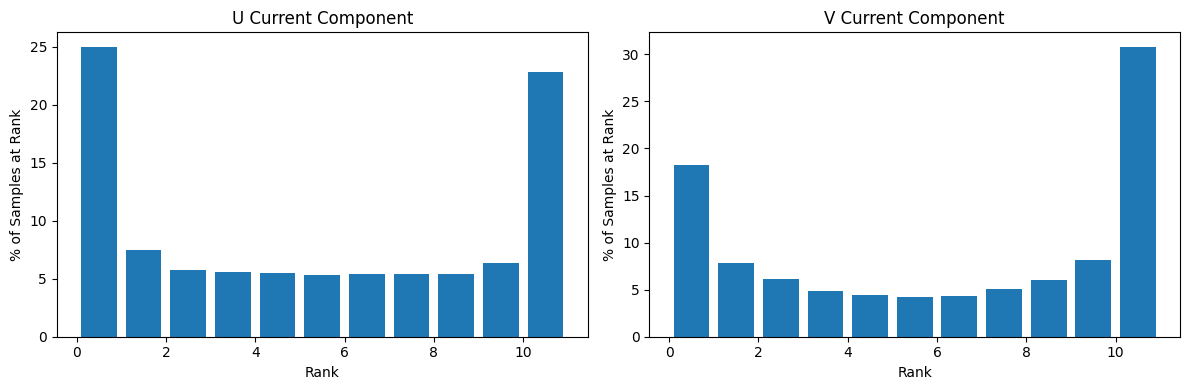

In [14]:
# GAN preds
files = sorted(os.listdir(error_root))
rank_histograms = []
for i, current_comp in enumerate(["u", "v"]):
    # get sparse gt and mask where zero
    errors = gt[:, i, :, :][np.where(gt[:, i, :, :] != 0)].flatten()
    num_ensembles = len(files)
    ensemble = np.zeros((len(errors), num_ensembles))
    for j in range(num_ensembles):
        ds = xr.load_dataset(os.path.join(error_root, files[j]))
        data = ds[f"water_{current_comp}"].values
        # add data to ensemble data but mask same as gt
        ensemble[:, j] = data[np.where(gt[:, i, :, :] != 0)].flatten()

    rel_freq, bins = e.rankhist(ensemble, errors)
    rank_histograms.append([rel_freq, bins])

name_dict = {0: "U", 1: "V"}
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i, ax in enumerate(axs):
    bins = rank_histograms[i][1]
    rel_freq = rank_histograms[i][0]
    ax.bar(bins[1:len(bins)], rel_freq*100)
    ax.set_ylabel("% of Samples at Rank")
    ax.set_xlabel("Rank")
    ax.title.set_text(f"{name_dict[i]} Current Component")
plt.tight_layout()

# Temporal Smoothness

0.02841126856379484


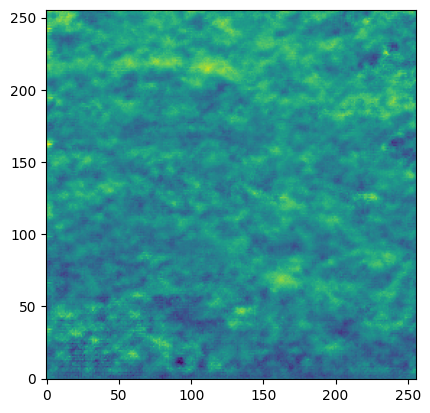

In [3]:
from ocean_navigation_simulator.generative_error_model.generative_model_metrics import temporal_smoothness

# temporal smoothness for GAN predictions
error_root = "../../../data/drifter_data/GAN_nc/currents"
files = sorted(os.listdir(error_root))
ds = xr.open_dataset(os.path.join(error_root, files[0]))
data = ds["water_u"].values

print(temporal_smoothness(data))

plt.imshow(data[0], origin="lower")

In [4]:
# temporal smoothness for forecast
fc_root = "../../../data/drifter_data/forecasts/area1"
files = sorted(os.listdir(fc_root))
print(files[139])
ds = xr.open_dataset(os.path.join(fc_root, files[139]))
data = ds["utotal"].values

print(temporal_smoothness(data))

cmems_mod_glo_phy_anfc_merged-uv_PT1H-i-2022-09-21T12:30:00Z-2022-09-21T12:30:00Z-2022-09-30T23:30:00Z.nc
0.008675354811859947


In [8]:
# temporal smoothness for simplex noise
data = xr.open_dataset("../../../data/drifter_data/test_noise.nc")
data = data["water_u"].values[:228]

ds = ds.sel(longitude=slice(-140, -120), latitude=slice(20, 30))
data_fc = ds["utotal"].values.squeeze()[:228]

fin_data = data + data_fc
print(fin_data.shape)

print(temporal_smoothness(data+data_fc))

(228, 121, 241)
0.011942311987381743


# Additive Magnitude

In [23]:
from ocean_navigation_simulator.generative_error_model.models.OceanCurrentNoiseField import OceanCurrentNoiseField
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os

# load HC
hc_path = "../../../data/drifter_data/hindcasts/area1"
files = sorted(os.listdir(hc_path))
num_file = int(0.9*len(files))
print(num_file)
file = files[num_file]
print(file)
file_path = os.path.join(hc_path, file)
hc = xr.open_dataset(file_path)
hc = hc.sel(lon=slice(-146.25, -125),
            lat=slice(15, 36.25))

139
copernicus_hindcast_lon_[-150, -115]_lat_[0, 40]_time_[2022-09-21 12:30:00,2022-09-30 12:30:00].nc


In [24]:
# get error

fc_dir = "../../../data/drifter_data/forecasts/area1"
files = sorted(os.listdir(fc_dir))
num_file = int(0.9*len(files))
print(num_file)
file = files[num_file]
print(file)
file_path = os.path.join(fc_dir, file)
fc = xr.open_dataset(file_path)
fc = fc.sel(longitude=slice(-146.25, -125),
            latitude=slice(15, 36.25))

# save fc data for inference
gan_data = np.concatenate([fc["utotal"].values, fc["vtotal"].values], axis=1)[:192]
new_dir = "../../../data/drifter_data/thesis_gan_inference"
fc_dir = os.path.join(new_dir, "forecast", "area1")
if not os.path.exists(fc_dir):
    os.makedirs(fc_dir)
np.save(os.path.join(fc_dir, f"fc_{datetime.datetime.now()}.npy"), gan_data)

# save gt for inference
gt = np.zeros((192, 2, 256, 256))
gt_dir = os.path.join(new_dir, "ground_truth", "area1")
if not os.path.exists(gt_dir):
    os.makedirs(gt_dir)
np.save(os.path.join(gt_dir, f"gt_{datetime.datetime.now()}.npy"), gt)

139
cmems_mod_glo_phy_anfc_merged-uv_PT1H-i-2022-09-21T12:30:00Z-2022-09-21T12:30:00Z-2022-09-30T23:30:00Z.nc


In [25]:
# preds_path = "../../../data/drifter_data/thesis_gan_inference/2022-12-08_15:27:39/output_0001.npy" # constrained
preds_path = "../../../data/drifter_data/GAN_samples/2022-12-11_10:26:04/output_0001.npy"  # unconstrained

preds = np.load(preds_path, allow_pickle=True)
preds = preds - gan_data

In [26]:
# get magnitudes
hc_mag = np.sqrt(hc["water_u"].values.squeeze()**2 + hc["water_v"].values.squeeze()**2)
noise_mag = np.sqrt(preds[:, 0, :, :] **2 + preds[:, 1, :, :]**2)

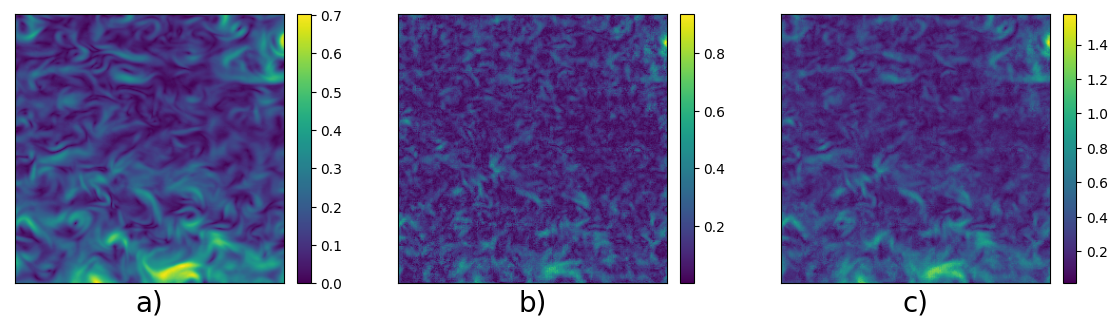

In [27]:
time_step = 0
# noise_mag = noise_mag*0.5
fig, axs = plt.subplots(1, 3, figsize=(14,3.5))
hc_frame = axs[0].imshow(hc_mag[time_step], origin="lower")
axs[0].set_xlabel("a)", fontdict={"size": 20})
plt.colorbar(hc_frame, ax=axs[0], fraction=0.046, pad=0.04)
noise_frame = axs[1].imshow(noise_mag[time_step], origin="lower")
axs[1].set_xlabel("b)", fontdict={"size": 20})
plt.colorbar(noise_frame, ax=axs[1], fraction=0.046, pad=0.04)
total_frame = axs[2].imshow(hc_mag[time_step] + noise_mag[time_step], origin="lower")
axs[2].set_xlabel("c)", fontdict={"size": 20})
plt.colorbar(total_frame, ax=axs[2], fraction=0.046, pad=0.04)

# Turn off tick labels
for i in range(3):
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

# Forecast - Synthetic Error Correlation


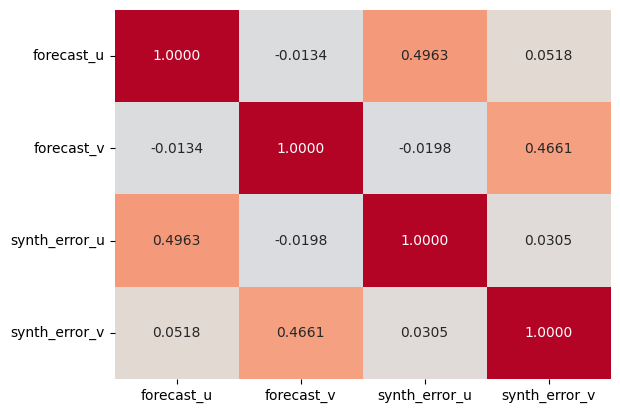

In [28]:
def get_file_list(dir: str) -> list[str]:
    return sorted(os.listdir(dir))

# load fc data
fc_root = "../../../data/drifter_data/GAN_nc/forecasts"
fc_files = get_file_list(fc_root)
fc = xr.open_dataset(os.path.join(fc_root, fc_files[0]))

# load error data
error_root = "../../../data/drifter_data/GAN_nc/errors_unconstrained"
error_files = get_file_list(error_root)
error = xr.open_dataset(os.path.join(error_root, error_files[2]))

# remove NaN values
fc_u = fc["water_u"].values[~np.isnan(fc["water_u"].values)]
fc_v = fc["water_v"].values[~np.isnan(fc["water_v"].values)]
synth_u = error["water_u"].values[~np.isnan(fc["water_u"].values.squeeze())]
synth_v = error["water_v"].values[~np.isnan(fc["water_v"].values.squeeze())]

df = pd.DataFrame({"forecast_u": fc_u, "forecast_v": fc_v, "synth_error_u": synth_u, "synth_error_v": synth_v})
plot_correlation_grid(df)